OBJ:
* Demo smooth pipeline for complete ML model.

In [1]:
import pandas as pd
import numpy as np

## Load data

In [2]:
from src.data.io import import_and_prep_target_df_from_pickle, import_and_merge_feature_dfs_from_pickles

In [3]:
df = import_and_prep_target_df_from_pickle('./../../../data/interim/D3_dailyTS/EDdaily_occupancy_class15_clipped.pkl')

df.head()

,flag_target,EDMeanOcc_prevday
dt_date,,
2011-09-01,0,NaN
2011-09-02,0,27.375000
2011-09-03,1,27.291667
2011-09-04,1,43.375000
2011-09-05,0,50.083333


In [4]:
df.shape

(2587, 2)

In [5]:
pickle_features_list = ['callender.pkl', 'EDmorn.pkl', 'IPmorn.pkl', 'IPprevday_summary.pkl', 'EDprevday_summary.pkl']
df2 = import_and_merge_feature_dfs_from_pickles('./../../../data/interim/D3_dailyTS/', pickle_features_list, df)
df2.head()

,flag_target,EDMeanOcc_prevday,year,month,holiday,christmas_period,Friday,Monday,Saturday,Sunday,...,IPDAILYpatients_total,IPDAILYpatients_nonelec,IPDAILYpatients_elec,IPDAILYpatients_daycase,IPDAILYage_mean_elecnonelec,IPDAILYage_75plus_elecnonelec,EDDAILYattendances,EDDAILYadmissions,EDDAILYage_mean,EDDAILYage_75plus
dt_date,,,,,,,,,,,,,,,,,,,,,
2011-09-01,0,NaN,2011,9,0,0,0.0,0.0,0.0,0.0,...,1467,941,280,246,57.0552,443,247,92,38.2834,32
2011-09-02,0,27.375000,2011,9,0,0,1.0,0.0,0.0,0.0,...,1506,947,297,262,57.2942,446,261,115,41.0958,35
2011-09-03,1,27.291667,2011,9,0,0,0.0,0.0,1.0,0.0,...,1437,941,277,219,57.1113,437,261,111,41.7126,40
2011-09-04,1,43.375000,2011,9,0,0,0.0,0.0,0.0,1.0,...,1168,910,200,58,59.3313,418,310,133,40.3387,43
2011-09-05,0,50.083333,2011,9,0,0,0.0,1.0,0.0,0.0,...,1142,905,186,51,59.042,415,337,131,39.8754,44


## Split data

In [6]:
from src.data.preprocess import make_timeseries_test_train_splits
X_train, X_test, y_train, y_test = make_timeseries_test_train_splits(df2, 'flag_target', 365)

DATA POINTS:
orig size 2587
training:  2222
testing:  365


## Prepare data

In [7]:
# version 19.2
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from src.data.preprocess import DataFrameSelector, DataFrameReform, MakeBooleanAnInteger

In [8]:
X_train.head(2)

,EDMeanOcc_prevday,year,month,holiday,christmas_period,Friday,Monday,Saturday,Sunday,Thursday,...,IPDAILYpatients_total,IPDAILYpatients_nonelec,IPDAILYpatients_elec,IPDAILYpatients_daycase,IPDAILYage_mean_elecnonelec,IPDAILYage_75plus_elecnonelec,EDDAILYattendances,EDDAILYadmissions,EDDAILYage_mean,EDDAILYage_75plus
dt_date,,,,,,,,,,,,,,,,,,,,,
2011-09-01,NaN,2011,9,0,0,0.0,0.0,0.0,0.0,1.0,...,1467,941,280,246,57.0552,443,247,92,38.2834,32
2011-09-02,27.375,2011,9,0,0,1.0,0.0,0.0,0.0,0.0,...,1506,947,297,262,57.2942,446,261,115,41.0958,35


In [9]:

bin_features = ['holiday','christmas_period','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
num_features = list(set(X_train.columns) - set(bin_features))
all_features = num_features + bin_features

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class TakeFirstDiff(BaseEstimator,TransformerMixin):
    """ Selects only columns provided as list when initialised.
    """
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        X = np.diff(X, 1, axis=0, prepend=0)
        X[0].fill(0)# place 0s in first column as it was created from appended first values. This still leaves a bogus first row.
        return X

In [16]:
#### make numerical and binary pipelines
num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_features)),
#     ('feature_filter',SelectKBest(f_classif,k='all')),
    ('firstdiff', TakeFirstDiff()),
    ('imputer',SimpleImputer(strategy='median')),
    ('std_scaler',StandardScaler()),
])

bin_pipeline = Pipeline([
    ('selector',DataFrameSelector(bin_features)),
    ('boolean_conversion',MakeBooleanAnInteger()),
    ('imputer',SimpleImputer(strategy='most_frequent')),
])


pipes_type_list = [
    ('num_pipeline',num_pipeline),
  ('bin_pipeline',bin_pipeline),
]


#### define all parts of preprocessing in pipeline
preprocess_pipeline = make_pipeline(
    FeatureUnion(transformer_list=pipes_type_list),
    DataFrameReform(all_features),
)

#### call pipeline
X_trainT = preprocess_pipeline.fit_transform(X_train,y_train)
X_trainT.head()

,IPMORNpatients_elecnonelec_ed,IPMORNage_75plus_elecnonelec,EDDAILYattendances,IPDAILYpatients_daycase,EDMORNage_75plus,EDDAILYadmissions,IPMORNpatients_nonelec,IPMORNpatients_total,IPDAILYpatients_nonelec,EDMeanOcc_prevday,...,EDMORNoccupancy,holiday,christmas_period,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,-0.004135,-0.003269,-0.001237,-0.000454,-0.001299,-0.001924,-0.003704,-0.002281,-0.002898,-0.001103,...,-0.001285,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.198934,-0.601366,0.468051,0.144859,-0.482426,1.558882,0.736531,0.790514,0.181949,-0.001103,...,-0.635674,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.968713,-0.772251,-0.001237,-0.390982,0.720391,-0.273369,-1.484172,-2.182468,-0.187745,-0.012947,...,1.267494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.061977,-0.003269,1.641271,-1.462665,-0.482426,1.491021,0.780074,-0.342050,-0.957941,2.284795,...,0.315910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.366580,1.278370,0.903819,-0.064028,-0.241862,-0.137646,1.215506,0.903771,-0.156937,0.952341,...,-1.481527,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model search

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, TimeSeriesSplit

In [19]:
classifier_pipeline = make_pipeline(
#     preprocess_pipeline,
    LogisticRegression(solver='liblinear',class_weight ='balanced')

)

In [20]:
param_grid = {
    'logisticregression__C':[0.01, 0.05, 0.1,0.2,0.3,0.5,0.7,1,3,10],
       'logisticregression__penalty':['l1','l2'],
    'logisticregression__class_weight':['balanced', None, {1: 10}, {1:3},{1:5}, {1: 20}],
       }

In [21]:
lgr_model = LogisticRegression(solver='liblinear',class_weight ='balanced')

In [25]:
param_grid = {
    'C':[0.01, 0.05, 0.1,0.2,0.3,0.5,0.7,1,3,10],
       'penalty':['l1','l2'],
    'class_weight':['balanced', None, {1: 10}, {1:3},{1:5}, {1: 20}],
       }

In [26]:
tscv = TimeSeriesSplit(n_splits=6)

In [27]:
grid_search = GridSearchCV(lgr_model, param_grid, cv=tscv, scoring='average_precision', return_train_score=True)
# brier_score_loss, average_precision
grid_search.fit(X_trainT, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=6),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 3, 10],
                         'class_weight': ['balanced', None, {1: 10}, {1: 3},
                                          {1: 5}, {1: 20}],
                         'penalty': ['l1', 'l2']},
     

In [28]:
import sklearn

In [29]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [30]:
grid_search.best_estimator_

LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
grid_search.best_params_

{'C': 0.3, 'class_weight': None, 'penalty': 'l1'}

## Evaluation using CV on training set

In [32]:
from src.eval.eval_utils import cross_val_predict_tscv, BinProbEval

In [33]:
proba_preds, label_preds, y_labels = cross_val_predict_tscv(grid_search.best_estimator_, X_trainT, y_train, n_splits = 4)

No handles with labels found to put in legend.


AUC:  0.805
F1 score:  0.366
accuracy:  0.856
precision score:  0.532
recall scare:  0.279


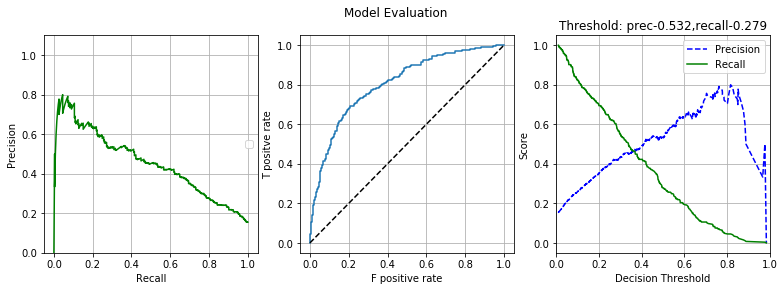

In [34]:
evaluation = BinProbEval(proba_preds, label_preds, y_labels, plot=True)

No handles with labels found to put in legend.


AUC:  0.852
F1 score:  0.505
accuracy:  0.845
precision score:  0.481
recall scare:  0.532


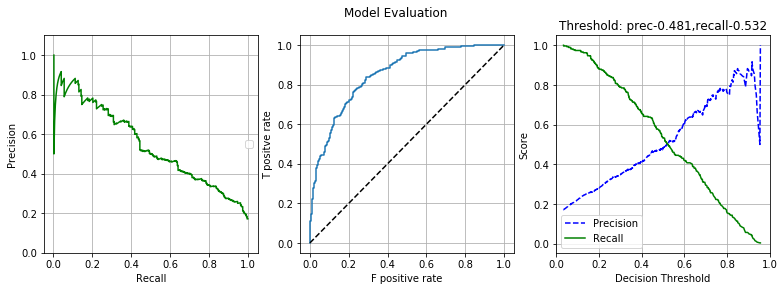

In [50]:
evaluation = BinProbEval(proba_preds, label_preds, y_labels, plot=True)

No handles with labels found to put in legend.


AUC:  0.839
F1 score:  0.434
accuracy:  0.874
precision score:  0.656
recall scare:  0.325


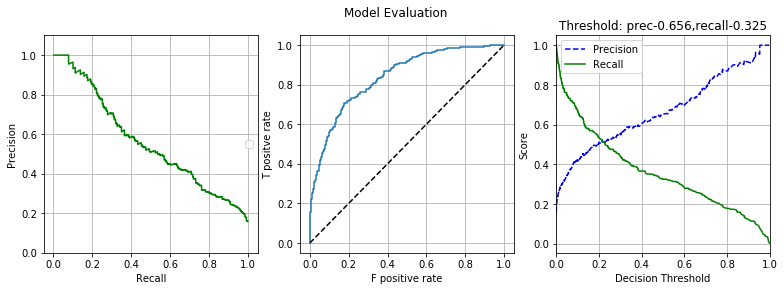

In [41]:
evaluation = BinProbEval(proba_preds, label_preds, y_labels, plot=True)

No handles with labels found to put in legend.


AUC:  0.851
F1 score:  0.509
accuracy:  0.869
precision score:  0.576
recall scare:  0.457


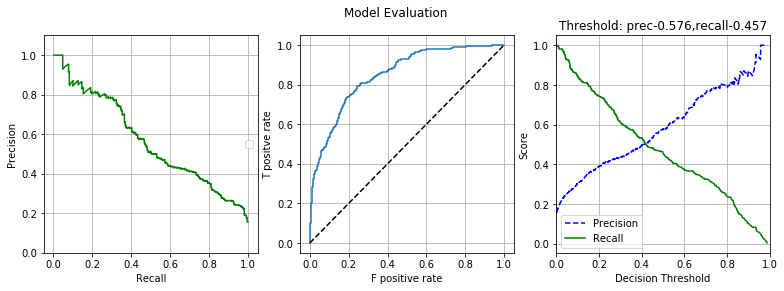

In [33]:
evaluation = BinProbEval(proba_preds, label_preds, y_labels, plot=True)

In [67]:
gridsearch_results = pd.DataFrame(grid_search.cv_results_)#.head(2)
gridsearch_results.query('rank_test_score == 1')['mean_train_score'].values.round(3)

array([-0.082])

#### saving model out

In [9]:
models = pd.read_pickle('./../../../data/output/models_log.pkl')
# models.drop(3,inplace=True)
models

,dataV,gridsearch,mean_train,mean_valid,model,notes
0,D3,mean_fit_time std_fit_time mean_score_t...,[-0.082],[-0.096],"LogisticRegression(C=0.2, class_weight=None, d...",Simple model from D3_FullPipelineExample-AllVa...
1,D3,mean_fit_time std_fit_time mean_score_t...,[-0.082],[-0.096],"LogisticRegression(C=0.2, class_weight=None, d...",Simple lgr model from D3_FullPipelineExample-A...


In [68]:
from src.eval.eval_utils import save_model_to_log

In [71]:
note = 'Simple lgr model from D3_FullPipelineExample-AllVars.ipynb. Contains all variables from morning and previous day.'

save_model_to_log('./../../../data/output/models_log.pkl','D3',grid_search.best_estimator_,grid_search,notes=note)

Model logged.


* think about what data need to reproduce
* write next function to reproduce plots
* 

In [72]:
break

SyntaxError: 'break' outside loop (<ipython-input-72-6aaf1f276005>, line 4)

#### make initla log file

In [73]:
df = pd.DataFrame()

In [29]:
df.to_pickle('./../../../data/output/models_log.pkl')

In [74]:
pd.read_pickle('./../../../data/output/models_log.pkl')

,dataV,gridsearch,mean_train,mean_valid,model,notes
0,D3,mean_fit_time std_fit_time mean_score_t...,[-0.082],[-0.096],"LogisticRegression(C=0.2, class_weight=None, d...",Simple model from D3_FullPipelineExample-AllVa...
1,D3,mean_fit_time std_fit_time mean_score_t...,[-0.082],[-0.096],"LogisticRegression(C=0.2, class_weight=None, d...",Simple lgr model from D3_FullPipelineExample-A...


No handles with labels found to put in legend.


AUC:  0.851
F1 score:  0.509
accuracy:  0.869
precision score:  0.576
recall scare:  0.457


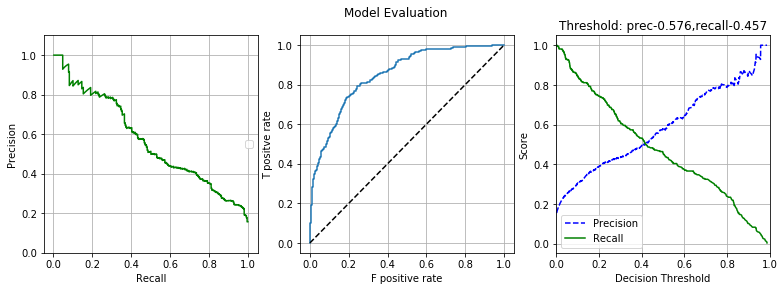

In [22]:
BinProbEval(proba_preds, label_preds, y_labels, plot=True)

In [24]:
for i in X_train.columns:
    print(i)

EDMeanOcc_prevday
flag_target_prevday
year
month
holiday
christmas_period
Friday
Monday
Saturday
Sunday
Thursday
Tuesday
Wednesday
EDMORNoccupancy
EDMORNage_mean
EDMORNage_75plus
IPMORNpatients_total
IPMORNpatients_nonelec
IPMORNpatients_elec
IPMORNpatients_daycase
IPMORNage_mean_elecnonelec
IPMORNage_75plus_elecnonelec
IPMORNwardmoves_mean_elecnonelec
IPMORNpatients_elecnonelec_gp
IPMORNpatients_elecnonelec_ed
IPDAILYpatients_total
IPDAILYpatients_nonelec
IPDAILYpatients_elec
IPDAILYpatients_daycase
IPDAILYage_mean_elecnonelec
IPDAILYage_75plus_elecnonelec
EDDAILYattendances
EDDAILYadmissions
EDDAILYage_mean
EDDAILYage_75plus


No handles with labels found to put in legend.


AUC:  0.851
F1 score:  0.509
accuracy:  0.869
precision score:  0.576
recall scare:  0.457


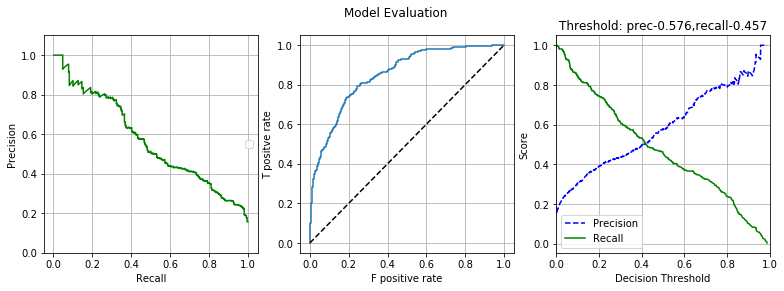

In [61]:
BinProbEval(proba_preds, label_preds, y_labels, plot=True)

No handles with labels found to put in legend.


AUC:  0.881
F1 score:  0.495
accuracy:  0.734
precision score:  0.345
recall scare:  0.875


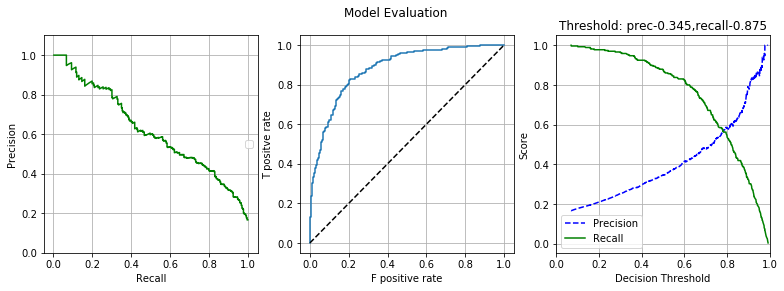

In [52]:
BinProbEval(proba_preds, label_preds, y_labels, plot=True)

No handles with labels found to put in legend.


AUC:  0.846
F1 score:  0.496
accuracy:  0.767
precision score:  0.366
recall scare:  0.766


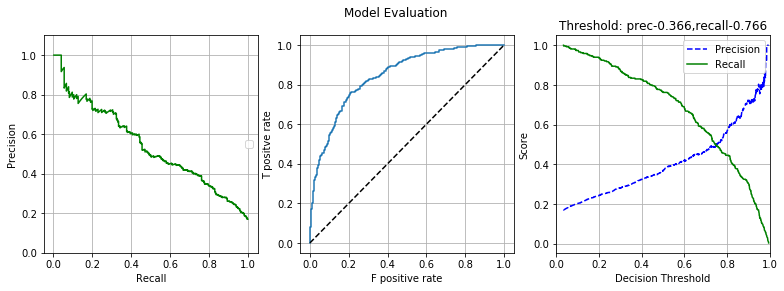

In [20]:
BinProbEval(proba_preds, label_preds, y_labels, plot=True)

In [25]:
for i in (X_trainT.columns):
    print(i)

year
month
EDMeanOcc_prevday
flag_target_prevday
EDMORNoccupancy
EDMORNage_75plus
EDMORNage_mean
holiday
christmas_period
Monday
Tuesday
Wednesday
Thursday
Friday
Saturday
Sunday


In [23]:
X_trainT.head(2)

,year,month,EDMeanOcc_prevday,flag_target_prevday,EDMORNoccupancy,EDMORNage_75plus,EDMORNage_mean,holiday,christmas_period,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,-1.789729,0.711161,-0.083565,-0.422084,-1.784788,-1.592424,-1.538231,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.789729,0.711161,-2.481070,-0.422084,-2.502688,-2.177617,-1.955488,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


No handles with labels found to put in legend.


AUC:  0.883
F1 score:  0.488
accuracy:  0.723
precision score:  0.337
recall scare:  0.883


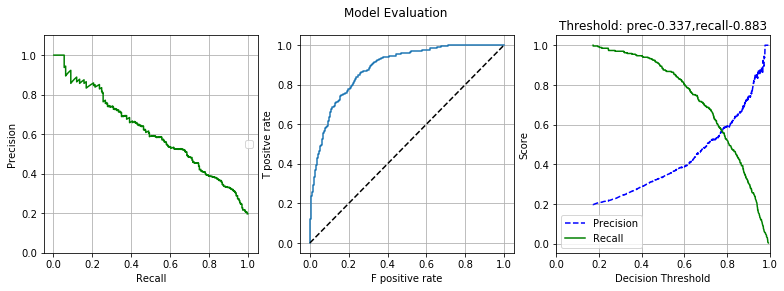

In [20]:
BinProbEval(proba_preds, label_preds, y_labels, plot=True)

No handles with labels found to put in legend.


AUC:  0.867
F1 score:  0.51
accuracy:  0.774
precision score:  0.377
recall scare:  0.789


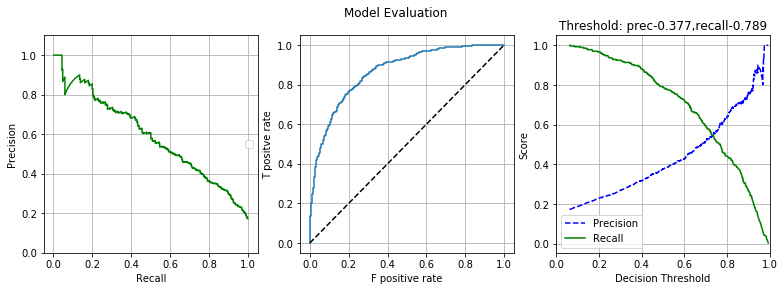

In [27]:
BinProbEval(proba_preds, label_preds, y_labels, plot=True)

No handles with labels found to put in legend.


AUC:  0.861
F1 score:  0.515
accuracy:  0.787
precision score:  0.39
recall scare:  0.758


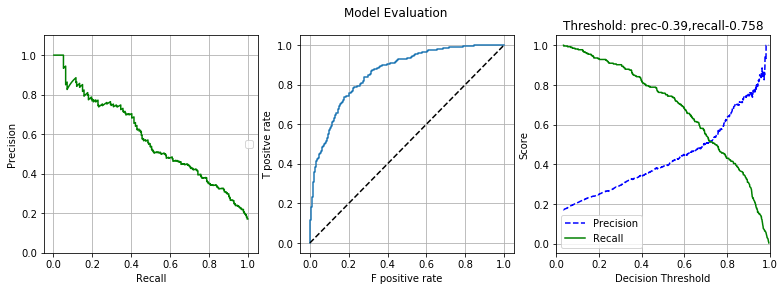

In [23]:
BinProbEval(proba_preds, label_preds, y_labels, plot=True)

No handles with labels found to put in legend.


AUC:  0.855
F1 score:  0.519
accuracy:  0.802
precision score:  0.407
recall scare:  0.717


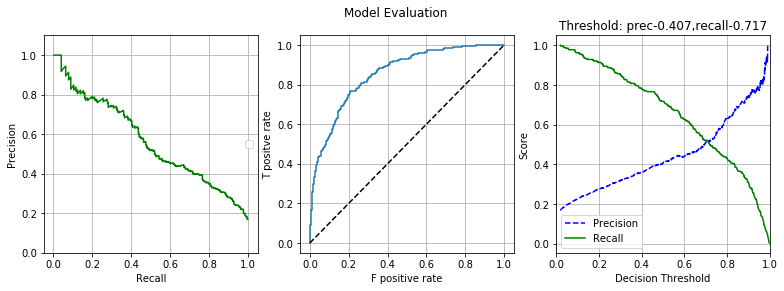

In [106]:
BinProbEval(proba_preds, label_preds, y_labels, plot=True)

NameError: name 'pd' is not defined

# Dev

In [ ]:
break

In [8]:
# version 19.2
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from src.data.preprocess import DataFrameSelector, MakeBooleanAnInteger


from sklearn.base import BaseEstimator, TransformerMixin


import numpy as np
import pandas as pd

In [38]:
X = np.array([[1, 2], [3, 4], [1, 2], [8, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])

In [39]:
X = pd.DataFrame(X,columns=['A','B'])

In [40]:
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names]#.values

In [41]:
pipel = DataFrameSelector(['A'])

In [42]:
pipel.fit_transform(X)

,A
0,1
1,3
2,1
3,8
4,1
5,3


In [43]:
#### failed to get this to work as kept doubling size of output array. Didnt matter if get_col_list_for_after_pipeline fundtion was inside or outside of DataFrameReform class.

class DataFrameReform(BaseEstimator,TransformerMixin):
    " Takes numpy array and forms into dataframe with column names."
    def __init__(self, cols_to_include):
        self.cols_to_include = cols_to_include
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        return (pd.DataFrame(X,columns=self.cols_to_include))

In [44]:
cols_to_include = ['B','A']

eg_pipeline = Pipeline([
    ('selector',DataFrameSelector(cols_to_include)),
#     ('imputer',SimpleImputer(strategy='median')),
    ('std_scaler',StandardScaler()),
    ('reform_df', DataFrameReform(cols_to_include)),
])

eg_pipeline.fit_transform(X)

,B,A
0,-1.0,-0.739940
1,1.0,0.067267
2,-1.0,-0.739940
3,1.0,2.085286
4,-1.0,-0.739940
5,1.0,0.067267


In [54]:
num_pipeline = Pipeline([
    ('selector',DataFrameSelector(['A','B'])),
    ('imputer',SimpleImputer(strategy='median')),
    ('std_scaler',StandardScaler()),
    ('reform_df', DataFrameReform),
])

df_reform_pipeline = Pipeline([
    ('reform_df', DataFrameReform),
])

pipes_list = [
    ('num_pipeline',num_pipeline),
#     ('df_reform_pipeline', df_reform_pipeline),
]

full_pipeline = FeatureUnion(transformer_list=pipes_list)

X_T = full_pipeline.fit_transform(X,y)

X_T

AttributeError: 'numpy.ndarray' object has no attribute 'fit'